In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy
import scipy.stats as stats
import numpy as np
import pickle

# Read CO2 data (for new 2018 data)

In [41]:
fCO2 = './../co2_temp_data/co2_mountloa_month.txt'
CO2 = pd.read_csv(fCO2, delim_whitespace=True, usecols=[2,4], index_col="decimal")
CO2.head()

,interpolated
decimal,
1958.208,315.71
1958.292,317.45
1958.375,317.50
1958.458,317.10
1958.542,315.86


In [42]:
CO2.rename(columns={"decimal": "year", "interpolated": "CO2"}, inplace=True)

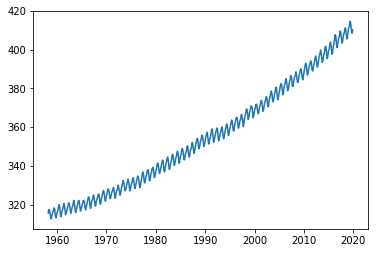

In [43]:
plt.plot(CO2)

In [48]:
CO2.tail()

,CO2
decimal,
2019.542,411.77
2019.625,409.95
2019.708,408.54
2019.792,408.53
2019.875,410.27


# GCP

In [59]:
fGCB = './../../Prelim_Data_Analysis/gcb_data/budget.csv'
df = pd.read_csv(fGCB,
                 index_col=0,
                 usecols=[0,4,5,6])
df.head()

,ocean sink,land sink,budget imbalance
Year,,,
1959,0.852376,0.516073,0.860316
1960,0.819017,1.394030,0.522722
1961,0.714842,0.605098,1.213762
1962,0.756709,1.348349,0.959605
1963,0.904997,0.877794,1.355333


In [60]:
fCO2 = './../co2_temp_data/co2_global.csv'
CO2 = pd.read_csv(fCO2, index_col="Year")
CO2.head()

,CO2
Year,
1957,314.231
1958,314.838
1959,315.486
1960,316.163
1961,316.856


In [61]:
CO2.loc[2018]=407.4
CO2.tail()

,CO2
Year,
2014,395.6510
2015,397.8860
2016,400.1300
2017,403.5225
2018,407.4000


In [62]:
df['CO2'] = CO2.CO2
df['land sink'] = -df['land sink']
df['ocean sink'] = -df['ocean sink']
df['budget imbalance'] = -df["budget imbalance"]+df['land sink']

df.head()

,ocean sink,land sink,budget imbalance,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


In [63]:
df.rename(columns={"ocean sink": "ocean", "land sink": "land (model)", "budget imbalance": "land"},
         inplace=True)
df.head()

,ocean,land (model),land,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


In [65]:
df.tail()

,ocean,land (model),land,CO2
Year,,,,
2014,-2.556489,-3.803287,-4.410669,395.6510
2015,-2.580257,-1.837847,-2.531232,397.8860
2016,-2.636438,-2.577243,-2.358355,400.1300
2017,-2.506476,-3.782197,-4.106298,403.5225
2018,-2.628250,-3.468828,-3.722246,407.4000


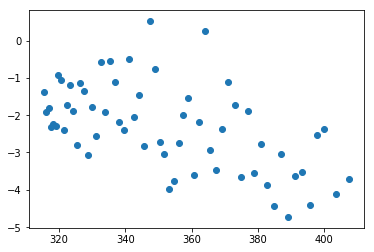

In [66]:
plt.scatter(df.CO2, df['land'])

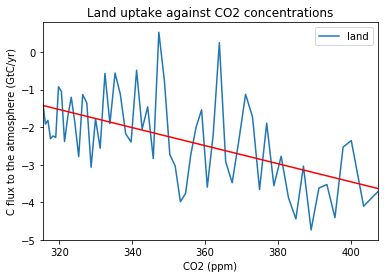

In [67]:
df.plot(x='CO2', y='land')
plt.xlabel("CO2 (ppm)")
plt.ylabel("C flux to the atmosphere (GtC/yr)")
plt.title("Land uptake against CO2 concentrations")

stats_land = stats.linregress(df['CO2'], df['land'])
plt.plot(df['CO2'], stats_land[0]*df['CO2']+stats_land[1], color='r')

Text(0.7, 0.95, 'slope: -0.024 GtC/yr/ppm\nr = -0.55')

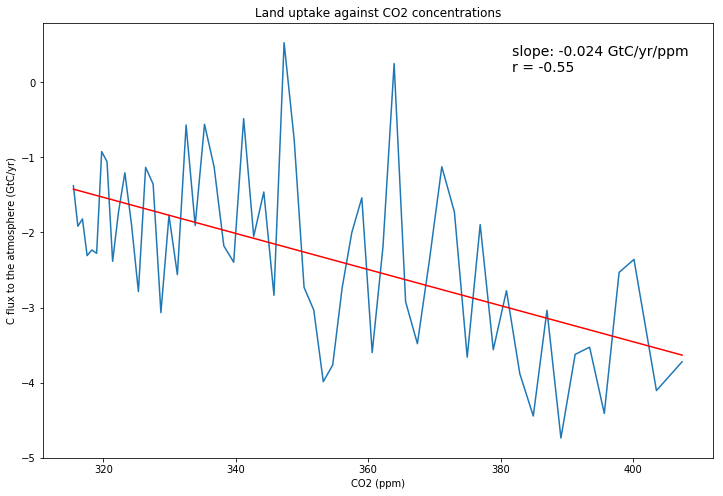

In [68]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df['CO2'], df['land'])
ax.set_xlabel("CO2 (ppm)")
ax.set_ylabel("C flux to the atmosphere (GtC/yr)")
ax.set_title("Land uptake against CO2 concentrations")

stats_land = stats.linregress(df['CO2'], df['land'])
plt.plot(df['CO2'], stats_land[0]*df['CO2']+stats_land[1], color='r')

textstr = '\n'.join(('slope: '+'%.3f' % stats_land[0]+' GtC/yr/ppm',
                     'r = '+'%.2f' % stats_land[2]))
ax.text(0.70, 0.95, textstr, fontsize=14, transform=ax.transAxes, verticalalignment='top')

In [69]:
stats_land

LinregressResult(slope=-0.02405532079319904, intercept=6.166513719652116, rvalue=-0.5521202081227151, pvalue=4.804258690074703e-06, stderr=0.004769874182764753)

Text(0.7, 0.95, 'slope: -0.018 GtC/yr/ppm\nr = -0.96')

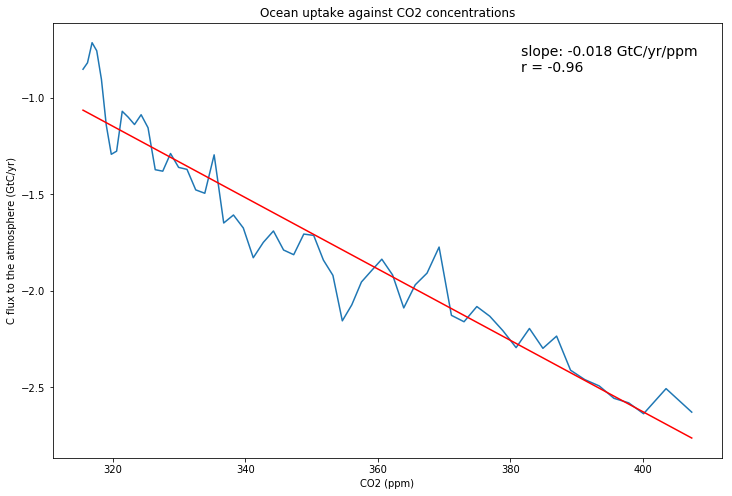

In [70]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df['CO2'], df['ocean'])
ax.set_xlabel("CO2 (ppm)")
ax.set_ylabel("C flux to the atmosphere (GtC/yr)")
ax.set_title("Ocean uptake against CO2 concentrations")

stats_ocean = stats.linregress(df['CO2'], df['ocean'])
plt.plot(df['CO2'], stats_ocean[0]*df['CO2']+stats_ocean[1], color='r')

textstr = '\n'.join(('slope: '+'%.3f' % stats_ocean[0]+' GtC/yr/ppm',
                     'r = '+'%.2f' % stats_ocean[2]))
ax.text(0.70, 0.95, textstr, fontsize=14, transform=ax.transAxes, verticalalignment='top')

In [77]:
def rolling_trend(data, sink='land', window=10, r_plot=False):
    
    data = data[['CO2', sink]]
    
    roll_values = []
    r_values = []
    
    for i in range(0,60-window):
        df = data.iloc[i:i+window+1]
        stats_info = stats.linregress(df['CO2'], df[sink])
        roll_values.append(stats_info[0])
        r_values.append(stats_info[2])
        
    data.plot(x='CO2', y=sink)
    plt.ylabel('C flux to the atmosphere (GtC)')
    
    roll_df = pd.DataFrame({f'{window}-year trend slope': roll_values}, index=data.index[:-window])
    roll_df.plot(color='g')
    plt.ylabel('Slope of C flux trend (GtC/ppm/yr)')
    plt.title(f"{sink} {window}-year trend timeseries")
    
    if r_plot:
        r_df = pd.DataFrame({'r-values of trends': r_values}, index=data.index[:-window])
        r_df.plot(color='k')
        plt.ylabel('r-value of slope')
        return roll_df, r_df
    
    return roll_df

In [78]:
p=df[['CO2', 'land']].iloc[0+30:11+30]
stats.linregress(p['CO2'], p['land'])

LinregressResult(slope=0.11382986820008272, intercept=-43.288716377728754, rvalue=0.4786130827447902, pvalue=0.1364149829266733, stderr=0.06960777463549518)

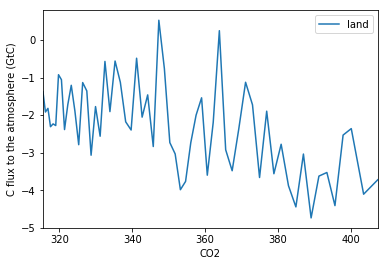

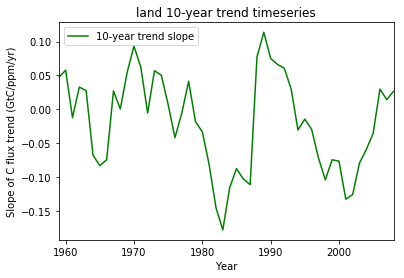

In [79]:
land_10_co2=rolling_trend(df, sink='land', window=10)
# plt.savefig('./../GCP_land.png')

In [80]:
land_10_co2

,10-year trend slope
Year,
1959,0.047010
1960,0.057761
1961,-0.012407
1962,0.032807
1963,0.027451
1964,-0.067753
1965,-0.083363
1966,-0.074494
1967,0.027107


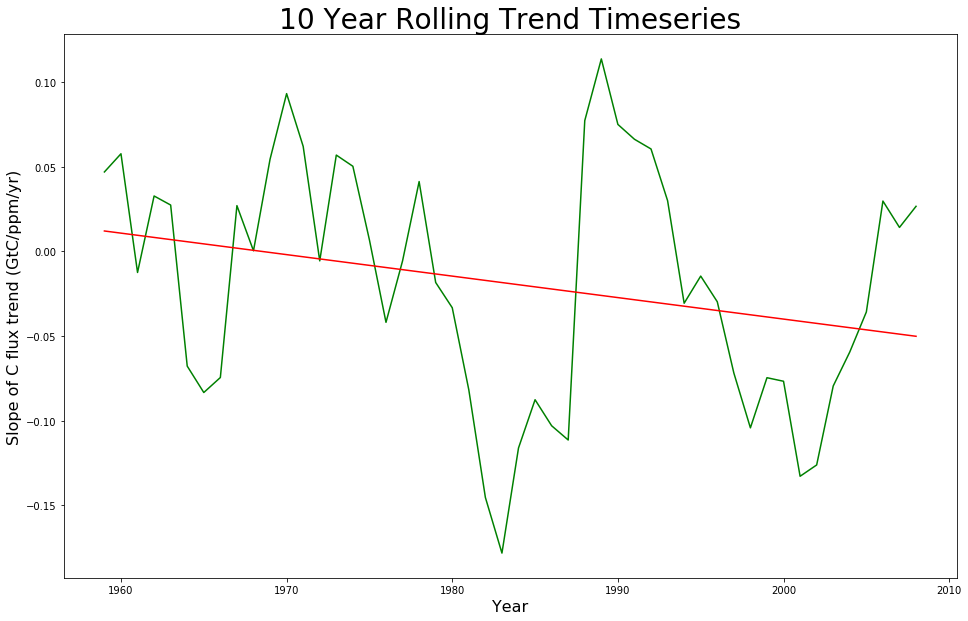

In [81]:
plt.figure(figsize=(16,10))

plt.plot(land_10_co2.index, land_10_co2, color='g')
plt.xlabel("Year", fontsize=16)
plt.ylabel('Slope of C flux trend (GtC/ppm/yr)', fontsize=16)
plt.title("10 Year Rolling Trend Timeseries", fontsize=28)

stats_land_roll = stats.linregress(land_10_co2.index, land_10_co2.values.squeeze())
plt.plot(land_10_co2.index, stats_land_roll[0]*land_10_co2.index+stats_land_roll[1], color='r')

# pickle
pickle.dump(land_10_co2, open("./rolling_land_plot.pik", "wb"))

In [82]:
land_10_co2.to_csv("land_rolling_trend.csv")

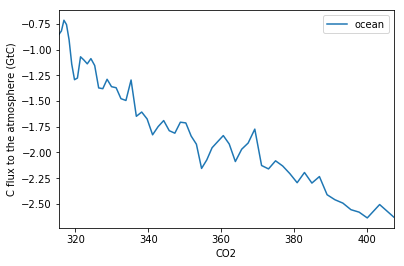

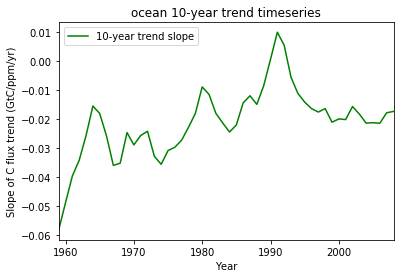

In [83]:
ocean_10_co2=rolling_trend(df, sink='ocean', window=10)
# plt.savefig('./../GCP_ocean.png')

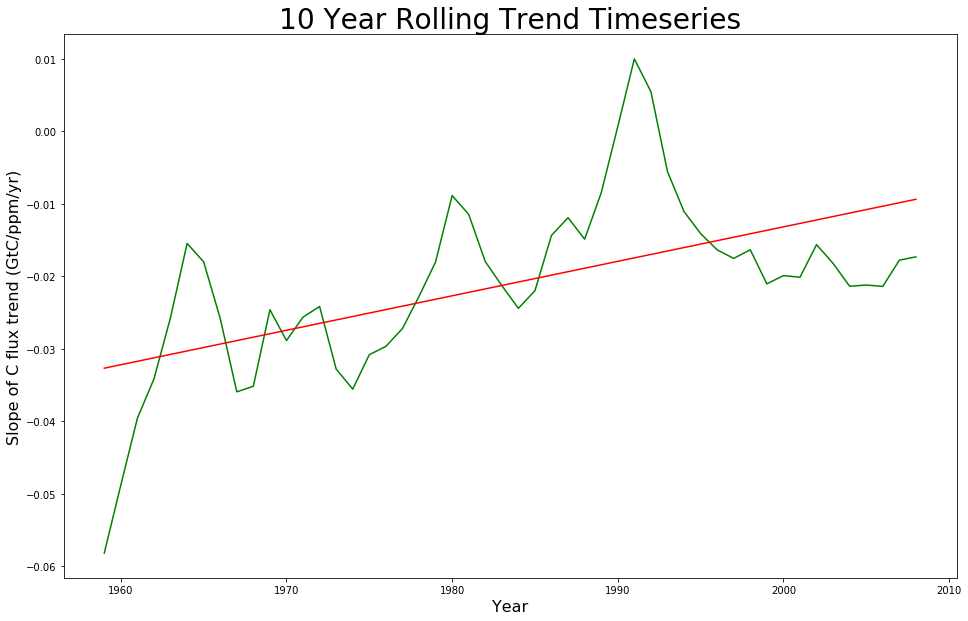

In [84]:
plt.figure(figsize=(16,10))

plt.plot(ocean_10_co2.index, ocean_10_co2, color='g')
plt.xlabel("Year", fontsize=16)
plt.ylabel('Slope of C flux trend (GtC/ppm/yr)', fontsize=16)
plt.title("10 Year Rolling Trend Timeseries", fontsize=28)

stats_ocean_roll = stats.linregress(ocean_10_co2.index, ocean_10_co2.values.squeeze())
plt.plot(ocean_10_co2.index, stats_ocean_roll[0]*ocean_10_co2.index+stats_ocean_roll[1], color='r')

# pickle
pickle.dump(ocean_10_co2, open("./rolling_ocean_plot.pik", "wb"))

In [85]:
ocean_10_co2.to_csv("ocean_rolling_trend.csv")

In [86]:
stats.linregress(land_10_co2.index, land_10_co2.values.squeeze())

LinregressResult(slope=-0.0012701695774711764, intercept=2.500378317604288, rvalue=-0.2607834166424348, pvalue=0.06737400906012585, stderr=0.0006786833758058246)

In [87]:
stats.linregress(ocean_10_co2.index, ocean_10_co2.values.squeeze())

LinregressResult(slope=0.00047535844299905524, intercept=-0.9639295029753573, rvalue=0.5768219143755571, pvalue=1.1624074786760961e-05, stderr=9.71654239757625e-05)

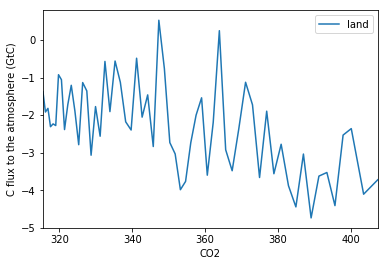

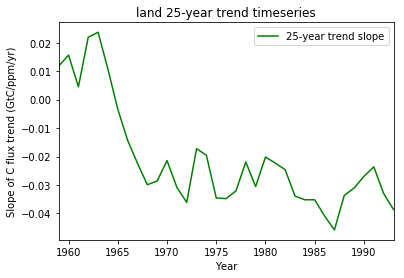

In [88]:
land_25_co2=rolling_trend(df, sink='land', window=25)

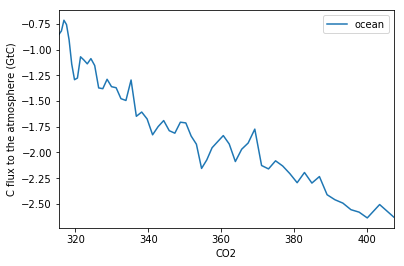

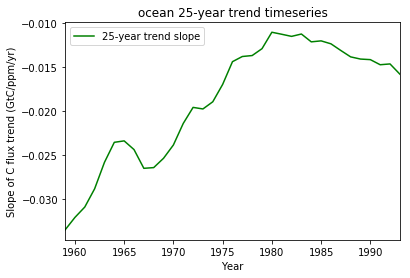

In [89]:
ocean_25_co2=rolling_trend(df, sink='ocean', window=25)

In [90]:
stats.linregress(land_25_co2.index, land_25_co2.values.squeeze())

LinregressResult(slope=-0.0013638850648914076, intercept=2.6740436038602358, rvalue=-0.7535825155546657, pvalue=1.7402948114491193e-07, stderr=0.00020710417478447197)

In [91]:
stats.linregress(ocean_25_co2.index, ocean_25_co2.values.squeeze())

LinregressResult(slope=0.0005793213159008478, intercept=-1.1635364589984583, rvalue=0.8731841905866538, pvalue=7.842204771003725e-12, stderr=5.629030676041495e-05)

# Integration to INVF.analysis

## Intro

In [17]:
import sys
sys.path.append("./../Scripts/")

import inv_flux as invf
import pickle

In [18]:
fJENA_s76 = "./../Output/output_raw/output_all/JENA_s76_all/year.pik"
JENA_s76 = pickle.load(open(fJENA_s76, "rb"))

JENA_s76

<xarray.Dataset>
Dimensions:         (time: 42)
Coordinates:
  * time            (time) object 1976-12-30 00:00:00 ... 2017-12-30 00:00:00
Data variables:
    Earth_Land      (time) float64 -1.222 0.7018 -0.7247 ... -1.454 -2.908
    South_Land      (time) float64 0.2531 0.4294 0.3338 ... 0.1559 0.05055
    Tropical_Land   (time) float64 -0.1174 0.9037 0.4336 ... 0.3215 -0.5574
    North_Land      (time) float64 -1.358 -0.6313 -1.492 ... -1.932 -2.401
    Earth_Ocean     (time) float64 -1.859 -1.456 -1.633 ... -2.054 -2.099 -2.661
    South_Ocean     (time) float64 -1.274 -1.044 -1.236 ... -1.348 -1.48 -1.736
    Tropical_Ocean  (time) float64 0.4939 0.6844 0.7426 ... 0.44 0.5199 0.238
    North_Ocean     (time) float64 -1.079 -1.096 -1.14 ... -1.146 -1.139 -1.163

## Add CO2 to annual datasets

In [19]:
def add_co2(file):
    df = pickle.load(open(file, "rb"))
    
    start_year = df.time.values[0].year
    end_year = df.time.values[-1].year
    
    vCO2 = CO2.loc[start_year:end_year].CO2.values
    
    return df.assign({"CO2": (("time"), vCO2)})


In [20]:
fRayner = "./../Output/output_raw/output_all/Rayner_all/year.pik"
fJENA_s76 = "./../Output/output_raw/output_all/JENA_s76_all/year.pik"
fJENA_s85 = "./../Output/output_raw/output_all/JENA_s85_all/year.pik"
fCTRACKER = "./../Output/output_raw/output_all/CTRACKER_all/year.pik"
fCAMS = "./../Output/output_raw/output_all/CAMS_all/year.pik"
fJAMSTEC = "./../Output/output_raw/output_all/JAMSTEC_all/year.pik"

In [21]:
output_file = "./../Output/output_raw/output_all/Rayner_all/year_wco2.pik"
pickle.dump(add_co2(fRayner), open(output_file, 'wb'))

In [22]:
output_file = "./../Output/output_raw/output_all/JENA_s76_all/year_wco2.pik"
pickle.dump(add_co2(fJENA_s76), open(output_file, 'wb'))

In [23]:
output_file = "./../Output/output_raw/output_all/JENA_s85_all/year_wco2.pik"
pickle.dump(add_co2(fJENA_s85), open(output_file, 'wb'))

In [24]:
output_file = "./../Output/output_raw/output_all/CTRACKER_all/year_wco2.pik"
pickle.dump(add_co2(fCTRACKER), open(output_file, 'wb'))

In [25]:
output_file = "./../Output/output_raw/output_all/CAMS_all/year_wco2.pik"
pickle.dump(add_co2(fCAMS), open(output_file, 'wb'))

In [26]:
output_file = "./../Output/output_raw/output_all/JAMSTEC_all/year_wco2.pik"
pickle.dump(add_co2(fJAMSTEC), open(output_file, 'wb'))

## Add rolling trend function

In [27]:
JENA_s76[["Earth_Land", "CO2"]]

KeyError: 'CO2'

In [28]:
JENA_s76["CO2"].values

KeyError: 'CO2'

In [29]:
pd.DataFrame({"CO2": JENA_s76["CO2"].values,
              "Earth_Land": JENA_s76["Earth_Land"].values,
              "Year": np.arange(JENA_s76.time.values[0].year, JENA_s76.time.values[-1].year+1)
             }).set_index("Year")

KeyError: 'CO2'

In [ ]:
len(JENA_s76.Earth_Land)

In [ ]:
def rolling_trend(self, variable, window_size=25, r_plot=False, save_plot=False):
    """ Calculates the slope of the trend of an uptake variable for each time window and for a given window size. The function also plots the slopes as a timeseries and, if prompted, the r-value of each slope as a timeseries.

    Parameters
    ----------
    variable: carbon uptake variable to regress.
    window_size: size of time window of trends.
    r_plot: If true, plots the r values of each slope as a timeseries.
    save_plot: save the plots as jpg files.

    """
     #self should be self.data
    start_year = self.time.values[0].year
    end_year = self.time.values[-1].year
    
    df = pd.DataFrame({"CO2": self["CO2"].values,
                       variable: self[variable].values,
                       "Year": np.arange(start_year, end_year+1)
             }).set_index("Year")

    roll_values = []
    r_values = []

    for i in range(0,len(self[variable])-window_size):
        subdf = df.iloc[i:i+window_size+1]
        stats_info = stats.linregress(subdf["CO2"], subdf[variable])
        roll_values.append(stats_info[0])
        r_values.append(stats_info[2])

    df.plot(x="CO2", y=variable)
    plt.ylabel("C flux to the atmosphere (GtC)")

    roll_df = pd.DataFrame({f"{window_size}-year trend slope": roll_values}, index=df.index[:-window_size])
    roll_df.plot(color='g')
    plt.ylabel("Slope of C flux trend (GtC/ppm/yr)")

    if r_plot:
        r_df = pd.DataFrame({"r-values of trends": r_values}, index=data.index[:-window_size])
        r_df.plot(color='k')
        plt.ylabel("r-value of slope")
        return roll_df, r_df

    return roll_df

In [ ]:
rolling_trend(self=JENA_s76, variable="Earth_Land", window_size=25);

## INVF Test

In [ ]:
import importlib as ilib

In [ ]:
ilib.reload(invf)

In [ ]:
JENA = invf.Analysis(JENA_s76)
JENA.data

In [ ]:
JENA.rolling_trend(variable='Earth_Land', window_size=10);

# Non-linear regression fits

In [ ]:
def plot_df_var(df, x="CO2", y="land"):
    plt.plot(df[x], df[y])
    
    xlabel=x
    if x=="CO2":
        xlabel=x+" (ppm)"
    plt.xlabel(xlabel)
    
    plt.ylabel("C flux to the atmosphere (GtC/yr)")
    plt.title(y)

In [ ]:
plot_df_var(df)

In [ ]:
plot_df_var(df, y='ocean')

In [ ]:
def func(x, a, b, c, d):
    return a*(x**3)+b*(x**2)+c*x+d

In [ ]:
popt_ocean, pcov_ocean = scipy.optimize.curve_fit(func, df['CO2'], df['ocean']) 
popt_ocean

In [ ]:
lin_ocean = stats.linregress(df['CO2'], df['ocean'])
lin_ocean

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(df['CO2'], func(df['CO2'], *popt_ocean), 'r-')
plt.plot(df['CO2'], lin_ocean[0]*df['CO2']+lin_ocean[1], 'g-')
plot_df_var(df, y='ocean')

In [ ]:
acc_ocean=popt_ocean[0]*2; acc_ocean

In [ ]:
popt_land, pcov_land = scipy.optimize.curve_fit(func, df['CO2'], df['land']) 
popt_land

In [ ]:
lin_land = stats.linregress(df['CO2'], df['land'])
lin_land

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(df['CO2'], func(df['CO2'], *popt_land), 'r-')
plt.plot(df['CO2'], lin_land[0]*df['CO2']+lin_land[1], 'g-')
plot_df_var(df, y='land')

In [ ]:
acc_land=popt_land[0]*2; acc_land

## Slope temp. vs. conc

In [ ]:
temp=pd.read_csv('./../co2_temp_data/temp_annual.csv', index_col='Year')
temp.head()

In [ ]:
CO2.head()

In [ ]:
stats.linregress(CO2.values.squeeze(), temp.values.squeeze())

In [ ]:
plt.plot(CO2.values.squeeze(), temp.values.squeeze())

In [ ]:
stats.linregress(df["CO2"], df["land"])

In [ ]:
plot_df_var(df)

# Regression of Friedlingstein feedback eqn

dU = beta * dC + gamma * dT

regress -dU against dC, slope = beta and intercept = gamma * dT

In [46]:
C = df.CO2
C.head()

Year
1959    315.486
1960    316.163
1961    316.856
1962    317.558
1963    318.268
Name: CO2, dtype: float64

In [48]:
land = -df.land
land.head()

Year
1959    1.376389
1960    1.916752
1961    1.818860
1962    2.307954
1963    2.233127
Name: land, dtype: float64

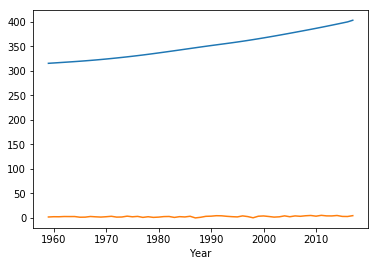

In [49]:
C.plot(); land.plot()

In [63]:
stats_info = stats.linregress(C-280, land)
stats_info

LinregressResult(slope=0.023930300605221336, intercept=0.5764234984647114, rvalue=0.5358735325843046, pvalue=1.2206527776897123e-05, stderr=0.004993951437733341)

In [64]:
beta = stats_info[0] # slope = beta
intercept = stats_info[1]
beta, intercept

(0.023930300605221336, 0.5764234984647114)

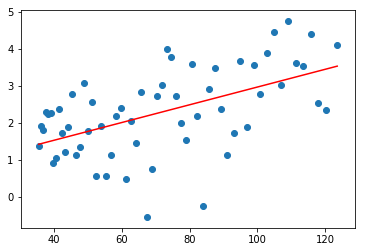

In [68]:
y = beta*(C-280)+ intercept
plt.plot(C-280,y, color='r')
plt.scatter(C-280, land)

In [71]:
# dT around 1 degC
gamma = intercept/1
gamma

0.5764234984647114

Caveats:
- make sure that the values of C, land and dT are correct in accordance to feedback analysis in Friedlingstein2003.
- temperature has changed over the years too, can't just assign dT to one value. It means that temperature influences uptake non-linearly. Could we 'adjust' this by implementing the dT for each year (which would increase the intercept incremently each year)?